In [ ]:
import json
import random
from tqdm.auto import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [ ]:
def set_seed(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [ ]:
!wget https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/year21-22/homework2/data/processed_corpus.json.zip

--2021-11-20 13:06:00--  https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/year21-22/homework2/data/processed_corpus.json.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3052590 (2.9M) [application/zip]
Saving to: ‘processed_corpus.json.zip’

processed_corpus.js 100%[===================>]   2.91M  --.-KB/s    in 0.07s   

2021-11-20 13:06:00 (44.6 MB/s) - ‘processed_corpus.json.zip’ saved [3052590/3052590]



In [ ]:
!unzip processed_corpus.json.zip

Archive:  processed_corpus.json.zip
  inflating: processed_corpus.json   


In [ ]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [ ]:
len(corpus)

100000

In [ ]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [ ]:
sample_text = corpus[1]

In [ ]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [ ]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    len_tokens = len(tokens)

    for t in range(len_tokens):

        start = t - window
        end = t + window + 1

        left_context = [tokens[i] if 0 <= i else pad_token for i in range(start, t)]
        central_word = tokens[t]
        right_context = [tokens[i] if i < len_tokens else pad_token for i in range(t+1, end)]

        splits.append((left_context, central_word, right_context))

        
    return splits

In [ ]:
splits = cbow_split(sample_text, window=2)

In [ ]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [ ]:
splits

[(['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']),
 (['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']),
 (['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']),
 (['денежный', 'средство'], 'лицевой', ['счёт', 'либо']),
 (['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']),
 (['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']),
 (['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']),
 (['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']),
 (['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']),
 (['счёт', 'погашение'], 'кредит', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [ ]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']),
 (['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']),
 (['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']),
 (['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']),
 (['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']),
 (['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']),
 (['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']),
 (['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']),
 (['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']),
 (['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [ ]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [ ]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    len_tokens = len(tokens)
    
    for t in range(len(tokens)):

        start = t - window
        end = t + window + 1

        sample = [(tokens[i], tokens[t]) for i in range(start, end) if (0 <= i < len_tokens and i != t)]
        splits.extend(sample)

    return splits

In [ ]:
splits = skipgram_split(sample_text, window=2)

In [ ]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [ ]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [ ]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [ ]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [ ]:
len(word2index)

13076

In [ ]:
word2index['UNK']

1

In [ ]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [ ]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.47132602, 0.40956052, 0.70276825, 0.9845238 ],
       [0.74660942, 0.63420977, 0.6950049 , 0.04564711],
       [0.33846455, 0.29263384, 0.43455712, 0.69135487],
       [0.31603279, 0.16780645, 0.30403494, 0.67602308],
       [0.96611203, 0.00665099, 0.43836615, 0.84927358],
       [0.35042586, 0.94912295, 0.17165057, 0.50037121],
       [0.61653211, 0.17065575, 0.12119598, 0.05755701],
       [0.33682667, 0.59386087, 0.53247902, 0.21122704],
       [0.75470105, 0.21876198, 0.64879016, 0.91885752],
       [0.25558448, 0.19937381, 0.33043493, 0.05614157]])

In [ ]:
some_data_y

array([0, 2, 0, ..., 0, 1, 1])

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [ ]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
some_dataset[5], some_dataset[467]

((array([0.35042586, 0.94912295, 0.17165057, 0.50037121]), 2),
 (array([0.76952042, 0.12132553, 0.18954682, 0.73632079]), 2))

In [ ]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [ ]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.5041, 0.8070, 0.1216, 0.4177],
         [0.4683, 0.8748, 0.6544, 0.0188],
         [0.6577, 0.5805, 0.9815, 0.3137],
         [0.3571, 0.0386, 0.8587, 0.5295],
         [0.0703, 0.3415, 0.2224, 0.9073],
         [0.7708, 0.9678, 0.4584, 0.0415],
         [0.9626, 0.8980, 0.9708, 0.3133],
         [0.3854, 0.0043, 0.2466, 0.9843],
         [0.4311, 0.7593, 0.0551, 0.9967],
         [0.4537, 0.2753, 0.6493, 0.5277],
         [0.1153, 0.6748, 0.0687, 0.9869],
         [0.3962, 0.3742, 0.4209, 0.2805],
         [0.1505, 0.9846, 0.7770, 0.5301],
         [0.8272, 0.4758, 0.6256, 0.4519],
         [0.5901, 0.6866, 0.7526, 0.1036],
         [0.9765, 0.7174, 0.5462, 0.9064]], dtype=torch.float64))

In [ ]:
for x, y in some_loader:
    pass

len(x)

15

In [ ]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [ ]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [ ]:
for x, y in toy_loader:
    break

In [ ]:
x.shape

torch.Size([128, 32])

In [ ]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.4713,   0.4096,   0.7028,  ...,  -5.3560,  -2.1164,  -0.0936],
        [  0.7466,   0.6342,   0.6950,  ...,  -2.7323,  -2.1830, -18.5209],
        [  0.3385,   0.2926,   0.4346,  ...,  -7.3730,  -5.0006,  -2.2146],
        ...,
        [  0.5068,   0.1451,   0.0657,  ..., -11.5830, -16.3393,  -0.6690],
        [  0.8260,   0.6644,   0.7035,  ...,  -2.4528,  -2.1102,  -1.9676],
        [  0.1148,   0.6689,   0.5492,  ...,  -2.4125,  -3.5956,  -0.3321]],
       dtype=torch.float64)

In [ ]:
y

tensor([0, 2, 0, 1, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0,
        0, 2, 1, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 0,
        1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2,
        0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0, 2, 0, 2, 2, 1, 2, 2,
        2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 1,
        2, 0, 2, 2, 1, 0, 1, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.151253342628479

# Боевые датасеты

In [ ]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [ ]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.window = window
        self.unk_token = unk_token
        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        splits = []
    
        len_tokens = len(tokenized_text)
        
        for t in range(len(tokenized_text)):

            start = t - self.window
            end = t + self.window + 1

            sample = [(tokenized_text[i], tokenized_text[t]) for i in range(start, end) if (0 <= i < len_tokens and i != t)]
            splits.extend(sample)

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]
 
    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]
        context = torch.tensor(context)

        return context, central_word

In [ ]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [ ]:
dataset = SkipgramDataset(corpus, word2index)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE = 512

In [ ]:
set_seed(42)
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
for x, y in dataset_loader:
    break

In [ ]:
x[:5]

tensor([  25,  409, 6429,   48, 1787])

In [ ]:
y[:5]

tensor([ 2404,    88,    28,   512, 10078])

In [ ]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [ ]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [ ]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
    
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
    

    def forward(self, x):

        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x



In [ ]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [ ]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [ ]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

# Допишите обучалку

In [ ]:
# сделаю в функцию потому что с гпу удобнее

def train(dataloader, model, optimizer, criterion, device, epochs=3, scheduler=None):
    losses = []

    model.to(device)
    model.train()

    for n_epoch in range(epochs):

        progress_bar = tqdm(total=len(dataloader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataloader:

            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            pred = model(x)
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

        # это спойлер не смотрите сюда
        if scheduler:
            scheduler.step()

    return losses


In [ ]:
set_seed(100)
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# мне лень ждать
device = ('cuda' if torch.cuda.is_available() else 'cpu')
losses = train(dataset_loader, model, optimizer, criterion, device, epochs=3)

Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [ ]:
def plot_loss(loss):
    plt.title('SkipGram Training Process')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.plot(loss)
    plt.show()

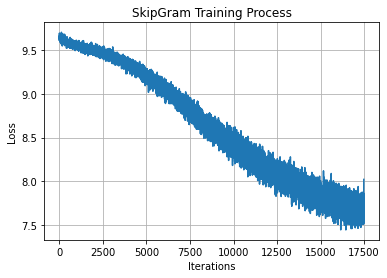

In [ ]:
plot_loss(losses)

In [ ]:
# проверка, что хоть что-то выучилось
# assert np.mean(losses[-1000:]) < 7.5

In [ ]:
embedding_matrix = model.in_embedding.weight.detach().cpu()

In [ ]:
def cos_sim(word1, word2, embedding_matrix=embedding_matrix, token2id=word2index):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [ ]:
cos_sim('день', 'месяц', embedding_matrix, word2index)

0.06453457474708557

In [ ]:
cos_sim('минута', 'месяц', embedding_matrix, word2index)

0.1882592737674713

In [ ]:
cos_sim('сотрудник', 'сотрудница', embedding_matrix, word2index)

0.16086141765117645

In [ ]:
cos_sim('вклад', 'перевод', embedding_matrix, word2index)

0.2505335509777069

In [ ]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim('день', random_word, embedding_matrix, word2index)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "захотеться" равна -0.008'

In [ ]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [ ]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [ ]:
set_seed(1)
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=0)
reduced = tsne.fit_transform(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
top_words = [a for a,_ in top_sorted_freq]

In [ ]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

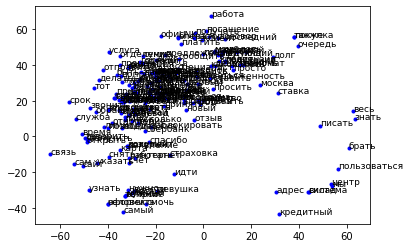

In [ ]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x, y, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

## Часть 2

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv', sep='\t')
data.rename(columns={'# Word1': 'word1', 'Word2': 'word2', 'Average Score': 'simlex'}, inplace=True)  # для удобства
data

,word1,word2,simlex
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23
...,...,...,...
960,яблоко_NOUN,солнце_NOUN,0.15
961,ядро_NOUN,пушка_NOUN,2.77
962,язык_NOUN,горло_NOUN,1.38
963,ярд_NOUN,дюйм_NOUN,2.62


Почистим ланные и отфильтруем все слова, которых нет в модели:

In [ ]:
def strip_word(word):
    return word.split('_')[0]


def in_model(word):
    if word in word2index:
        return True
    return False


In [ ]:
data.word1 = data.word1.apply(strip_word)
data.word2 = data.word2.apply(strip_word)
data = data.loc[(data.word1.apply(in_model) & data.word2.apply(in_model)), :]
data

,word1,word2,simlex
1,август,месяц,2.85
3,автомобиль,гудок,1.85
5,автомобиль,такси,4.15
7,автомобиль,велосипед,1.38
9,автомобиль,мост,1.15
...,...,...,...
952,юбилей,год,2.69
953,юбилей,дата,6.62
954,юг,север,0.00
955,юрист,банкир,1.15


Отнормируем скоры:

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
data.simlex = scaler.fit_transform(np.expand_dims(data.simlex.values, axis=0).T)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
data.head()

,word1,word2,simlex
1,август,месяц,0.287298
3,автомобиль,гудок,0.186492
5,автомобиль,такси,0.418347
7,автомобиль,велосипед,0.139113
9,автомобиль,мост,0.115927


In [ ]:
from sklearn.metrics import mean_squared_error


def check_embs(data, model):

    embedding_matrix = model.in_embedding.weight.detach().cpu()

    sim = [cos_sim(data.word1.values[i], data.word2.values[i], embedding_matrix) for i in range(len(data))]

    scaler = MinMaxScaler()
    sim = scaler.fit_transform(np.expand_dims(sim, axis=0).T)

    return mean_squared_error(sim, data.simlex)

In [ ]:
initial_pred = check_embs(data, model)
initial_pred

0.15596149397187697

## Часть 3: эксперименты


Во-первых, если посмотреть на график лосса, то увидим, что lr слишком маленький...
Во-вторых, если посмотреть на обучение модели изначально, то заметим, что lr скачет вокруг 7.6 но не попадает в минимум 

Соответсвенно, первое что попробуем -- сделать scheduler

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

In [ ]:
set_seed(42)

loss_dict = []

for lr in [0.001, 0.005, 0.01]:
    for gamma in [0.0001, 0.001, 0.005]:
        if lr - gamma * 2 <= 0:
            continue

        print(f'lr={lr}, gamma={gamma}')
        model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        scheduler = ExponentialLR(optimizer, gamma=gamma)
        criterion = torch.nn.CrossEntropyLoss()

        loss = train(dataset_loader, model, optimizer, criterion, device, epochs=3, scheduler=scheduler)

        mse = check_embs(data, model)

        loss_dict.append({'emb_dim': EMBEDDING_DIM,
                          'epochs': 3,
                          'scheduler': 'exp',
                          'lr': lr,
                          'gamma': gamma,
                          'loss': loss,
                          'mse': mse,
                          'model': model})


lr=0.001, gamma=0.0001


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

lr=0.005, gamma=0.0001


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

lr=0.005, gamma=0.001


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

lr=0.01, gamma=0.0001


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

lr=0.01, gamma=0.001


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [ ]:
set_seed(42)

epochs = 3
lr_lambda = lambda epoch: (epochs - epoch) / epochs

for lr in [0.001, 0.005, 0.01, 0.025]:

    print(f'lr={lr}')
    model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()

    loss = train(dataset_loader, model, optimizer, criterion, device, epochs=epochs, scheduler=scheduler)
    
    mse = check_embs(data, model)

    loss_dict.append({'emb_dim': EMBEDDING_DIM,
                      'epochs': 3,
                      'scheduler': 'lambda',
                      'lr': lr,
                      'gamma': None,
                      'loss': loss,
                      'mse': mse,
                      'model': model})

lr=0.001
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6667e-04.


Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-04.


Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.
lr=0.005
Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-03.


Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6667e-03.


Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.
lr=0.01
Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6667e-03.


Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-03.


Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.
lr=0.025
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6667e-02.


Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3333e-03.


Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.


Посмотрим на лучшую модель по лоссу:

In [ ]:
best_params_loss = sorted(loss_dict, key=lambda x: np.mean(x['loss'][-100:]))[0]

In [ ]:
def print_params(parameters):
    param_str = "dim:\t{emb_dim}\nepochs:\t{epochs}\nsch:\t{scheduler}\nlr:\t{lr}\ngamma:\t{gamma}"
    print('Параметры модели:')
    print(param_str.format(emb_dim=parameters['emb_dim'],
                           epochs=parameters['epochs'],
                           scheduler=parameters['scheduler'],
                           lr=parameters['lr'],
                           gamma=parameters['gamma']))

In [ ]:
print_params(best_params_loss)

Параметры модели:
dim:	20
epochs:	3
sch:	lambda
lr:	0.01
gamma:	None


loss: 6.6734292650222775


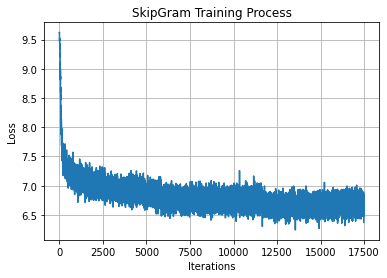

In [ ]:
print('loss:', np.mean(best_params_loss['loss'][-100:]))
plot_loss(best_params_loss['loss'])

In [ ]:
print('init:', initial_pred, sep='\t')
print('new:', best_params_loss['mse'], sep='\t')

init:	0.15596149397187697
new:	0.152354517038725


MSE опустилась, но совсем немного(
Но посмотрим еще и на лучшую модель по MSE:

In [ ]:
best_params_mse = sorted(loss_dict, key=lambda x: x['mse'])[0]

In [ ]:
print_params(best_params_mse)

Параметры модели:
dim:	20
epochs:	3
sch:	lambda
lr:	0.005
gamma:	None


loss: 6.71415566444397


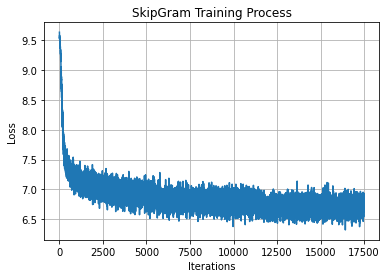

In [ ]:
print('loss:', np.mean(best_params_mse['loss'][-100:]))
plot_loss(best_params_mse['loss'])

In [ ]:
print('initial:', initial_pred, sep='\t')
print('best_loss:', best_params_loss['mse'], sep='\t')
print('best_mse:', best_params_mse['mse'], sep='\t')

initial:	0.15596149397187697
best_loss:	0.152354517038725
best_mse:	0.14281601421776996


Ура, мы уменьшили MSE!

Вроде уже все класс, выглядит неплохо, но попробуем последней модели добавить эпох:

In [ ]:
set_seed(42)

for epochs in [3, 5, 7, 10]:
    print(f'Num.Epochs={epochs}')
    model = SkipGram(vocab_size=len(word2index), embedding_dim=best_params_mse['emb_dim'])
    optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params_mse['lr'])
    if best_params_mse['gamma'] is None:
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
        sch_p = 'lambda'
    else:
        scheduler = ExponentialLR(optimizer, gamma=best_params_mse['gamma'])
        sch_p = 'exp'
    criterion = torch.nn.CrossEntropyLoss()

    loss = train(dataset_loader, model, optimizer, criterion, device, epochs=epochs, scheduler=scheduler)

    mse = check_embs(data, model)

    loss_dict.append({'emb_dim': best_params_mse['emb_dim'],
                      'scheduler': sch_p,
                      'lr': best_params_mse['lr'],
                      'gamma': best_params_mse['gamma'],
                      'loss': loss,
                      'epochs': epochs,
                      'mse': mse,
                      'model': model})
    

Num.Epochs=3


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Num.Epochs=5


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/2983124 [00:00<?, ?it/s]

Num.Epochs=7


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/2983124 [00:00<?, ?it/s]

Num.Epochs=10


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [ ]:
best_params_epoch = sorted(loss_dict, key=lambda x: x['mse'])[0]

In [ ]:
print_params(best_params_epoch)

Параметры модели:
dim:	20
epochs:	3
sch:	exp
lr:	0.005
gamma:	None


loss: 6.721203484535217


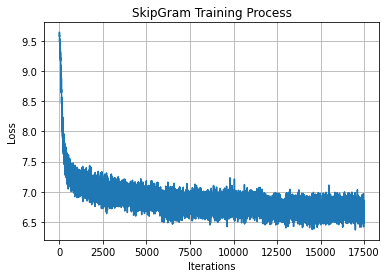

In [ ]:
print('loss:', np.mean(best_params_epoch['loss'][-100:]))
plot_loss(best_params_epoch['loss'])

In [ ]:
print('initial:', initial_pred, sep='\t')
print('best_mse:', best_params_mse['mse'], sep='\t')
print('best_epoch:', best_params_epoch['mse'], sep='\t')

initial:	0.15596149397187697
best_mse:	0.14281601421776996
best_epoch:	0.12833991255108204


Супер!!! Поэкспериментируем с размерностью эмбеддингов?

In [167]:
set_seed(42)
for i in [30, 50, 100, 300]:

    print(f'Emb_dim={i}')

    model = SkipGram(vocab_size=len(word2index), embedding_dim=i)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params_mse['lr'])
    if best_params_mse['gamma'] is None:
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
        sch_p = 'lambda'
    else:
        scheduler = ExponentialLR(optimizer, gamma=best_params_mse['gamma'])
        sch_p = 'exp'
    criterion = torch.nn.CrossEntropyLoss()

    loss = train(dataset_loader, model, optimizer, criterion, device, epochs=best_params_mse['epochs'], scheduler=scheduler)

    mse = check_embs(data, model)

    loss_dict.append({'emb_dim': i,
                      'scheduler': sch_p,
                      'lr': best_params_mse['lr'],
                      'gamma': best_params_mse['gamma'],
                      'loss': loss,
                      'epochs': best_params_mse['epochs'],
                      'mse': mse,
                      'model': model})


Emb_dim=30


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Emb_dim=50


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Emb_dim=100


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Emb_dim=300


Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [168]:
best_params_dim = sorted(loss_dict, key=lambda x: x['mse'])[0]

In [169]:
print_params(best_params_dim)

Параметры модели:
dim:	100
epochs:	3
sch:	lambda
lr:	0.005
gamma:	None


loss: 6.5927132749557495


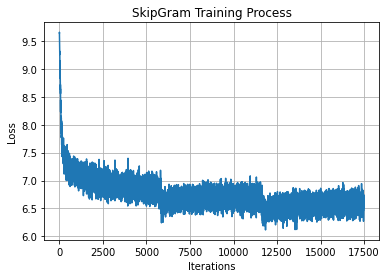

In [170]:
print('loss:', np.mean(best_params_dim['loss'][-100:]))
plot_loss(best_params_dim['loss'])

In [171]:
print('initial:', initial_pred, sep='\t')
print('best_mse:', best_params_mse['mse'], sep='\t')
print('best_dim:', best_params_dim['mse'], sep='\t')

initial:	0.15596149397187697
best_mse:	0.14281601421776996
best_dim:	0.10003781393358516


Ура!! Попробуем добавить пару эпох, вдруг будет меньше 0.10?


In [175]:
set_seed(42)
model = SkipGram(vocab_size=len(word2index), embedding_dim=best_params_dim['emb_dim'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params_dim['lr'])
if best_params_mse['gamma'] is None:
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    sch_p = 'lambda'
else:
    scheduler = ExponentialLR(optimizer, gamma=best_params_mse['gamma'])
    sch_p = 'exp'
criterion = torch.nn.CrossEntropyLoss()

loss = train(dataset_loader, model, optimizer, criterion, device, epochs=7, scheduler=scheduler)

mse = check_embs(data, model)

loss_dict.append({'emb_dim': best_params_dim['emb_dim'],
                  'scheduler': sch_p,
                  'lr': best_params_dim['lr'],
                  'gamma': best_params_dim['gamma'],
                  'loss': loss,
                  'epochs': 7,
                  'mse': mse,
                  'model': model})

Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [176]:
best_params_100 = sorted(loss_dict, key=lambda x: x['mse'])[0]

In [177]:
print_params(best_params_100)

Параметры модели:
dim:	100
epochs:	3
sch:	lambda
lr:	0.005
gamma:	None


loss: 6.5927132749557495


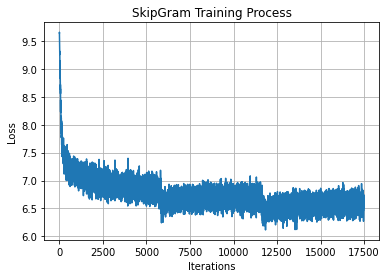

In [178]:
print('loss:', np.mean(best_params_100['loss'][-100:]))
plot_loss(best_params_100['loss'])

In [179]:
print('initial:', initial_pred, sep='\t')
print('best_dim:', best_params_dim['mse'], sep='\t')
print('best_100:', best_params_100['mse'], sep='\t')

initial:	0.15596149397187697
best_dim:	0.10003781393358516
best_100:	0.10003781393358516


Эх, эпохи не помогают.. Ну ничего, качество мы и так улучшили..

Ради интереса попробуем добавить байес в архитектуру:

In [180]:
class SkipGram2(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
    
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=True)
    

    def forward(self, x):

        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [186]:
set_seed(42)
model = SkipGram2(len(word2index), 100)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

epochs = 3
loss = train(dataset_loader, model, optimizer, criterion, device, epochs=3, scheduler=scheduler)

mse = check_embs(data, model)

loss_dict.append({'emb_dim': best_params_dim['emb_dim'],
                  'scheduler': sch_p,
                  'lr': best_params_dim['lr'],
                  'gamma': best_params_dim['gamma'],
                  'loss': loss,
                  'epochs': epochs,
                  'mse': mse,
                  'model': model,
                  'bias': True})

Epoch 1:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2983124 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2983124 [00:00<?, ?it/s]

In [189]:
best_params_all = sorted(loss_dict, key=lambda x: x['mse'])[0]

In [190]:
print_params(best_params_all)
print('bias' in best_params_all)

Параметры модели:
dim:	100
epochs:	3
sch:	lambda
lr:	0.005
gamma:	None
False


Шок bias не помог, тогда оставим модель с MSE 0.10..

Давайте посмотрим на количество обученных моделей ради интереса, а то я не считала:

In [192]:
len(loss_dict)

20

красиво..
